In [1]:
## Getting to Main directory
import os
os.chdir("../")

In [2]:
# !pip install -r requirements.txt

In [3]:
from typing import Dict, TypedDict
from langgraph.graph import StateGraph, END, START #Importing StateGraph, END, and START from langgraph.graph to define and manage state transitions within a conversational or generative AI workflow.
from langchain_core.prompts import ChatPromptTemplate
from langchain_google_genai import ChatGoogleGenerativeAI

from IPython.display import display, Image, Markdown
from langchain_core.runnables.graph import MermaidDrawMethod # to visualize the graph of langgraph node and edges
from dotenv import load_dotenv
import os

# Load environment variables from a .env file to access sensitive information
load_dotenv()

# Set the Gemini API key for authentication with Google Generative AI services
GOOGLE_API_KEY = os.environ["GOOGLE_API_KEY"] = os.getenv('GOOGLE_API_KEY')
# HF_TOKEN = os.environ["HF_TOKEN"] = os.getenv('HF_TOKEN')
# GEN_MODEL_ID = "deepseek-ai/deepseek-vl-1.3b-chat"

# Instantiate a chat model using Google's Gemini-1.5-flash with specified configurations
# - verbose=True enables detailed output logs for debugging
# - temperature=0.5 controls the creativity level in responses (lower values make responses more deterministic)
llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash",
                             verbose=True,
                             temperature=0.5,
                             google_api_key=os.getenv("GOOGLE_API_KEY"))


In [4]:
from langchain.chains.question_answering import load_qa_chain
from langchain.prompts import PromptTemplate

In [5]:
from langchain.vectorstores import FAISS
from langchain_google_genai import GoogleGenerativeAIEmbeddings
import google.generativeai as genai

genai.configure(api_key=GOOGLE_API_KEY)
embeddings = GoogleGenerativeAIEmbeddings(model="models/embedding-001")

In [6]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

class DocumentRetriever:
    def __init__(self, index_path, embeddings, top_k=7, k=25):
        """
        Initializes the retriever by loading the FAISS index and setting up embeddings.

        :param index_path: Path to the local FAISS index.
        :param embeddings: An embeddings object with an embed_documents method.
        :param k: Number of nearest neighbors to retrieve (for the FAISS retriever).
        """
        self.index_path = index_path
        self.embeddings = embeddings
        self.k = k
        self.top_k = top_k
        # Load the FAISS index as a retriever
        self.faiss_retriever = self._load_faiss_index()

    def _load_faiss_index(self):
        """
        Loads the FAISS index using the given embeddings.
        """
        retriever = (
            FAISS.load_local(
                self.index_path,
                self.embeddings,
                allow_dangerous_deserialization=True
            )
            .as_retriever(search_kwargs={"k": self.k})
        )
        return retriever

    def embed_documents(self, doc_strings):
        """
        Embeds a list of document strings and returns a numpy array of vectors.
        """
        vectors = self.embeddings.embed_documents(doc_strings)
        return np.array(vectors)

    def embed_query(self, query):
        """
        Embeds the user query and returns a 2D numpy array.
        """
        # Ensure query is embedded as a list, then get the first (and only) vector.
        query_vector = self.embeddings.embed_documents([query])[0]
        return np.array(query_vector).reshape(1, -1)

    def compute_similarity(self, query_vector, doc_vectors):
        """
        Computes cosine similarity between the query vector and document vectors.
        """
        # Returns a 1D array of similarity scores.
        return cosine_similarity(query_vector, doc_vectors)[0]

    def rerank_documents(self, user_query):
        """
        Reranks documents based on cosine similarity to the user query.

        :param doc_strings: List of document strings.
        :param user_query: The query string to compare against.
        :return: Tuple of (reranked_docs, similarity_scores, reranked_indices)
        """
        docs = self.faiss_retriever.invoke(user_query)
        # print(user_query)
        # print(doc_strings)
        # Get embeddings for documents and query
        doc_strings = [doc.page_content for doc in docs if len(doc.page_content)>200]
        # print("Checkpoint 1: Starting reranking process.")
        doc_vectors = self.embed_documents(doc_strings)
        # print("Checkpoint 2: Documents embedded.")
        query_vector = self.embed_query(user_query)
        # print("Checkpoint 3: Query embedded.")

        # Compute similarity scores between query and all documents
        similarity_scores = self.compute_similarity(query_vector, doc_vectors)
        # print("Checkpoint 4: Similarity scores computed.")
        
        # Rerank document indices by descending similarity
        reranked_indices = np.argsort(similarity_scores)[::-1]
        # print("Checkpoint 5: Indices reranked.")
        reranked_docs = [doc_strings[i] for i in reranked_indices]
        # reranked_info = [doc_strings[i] for i in reranked_indices]
        reranked_docs = reranked_docs[:self.top_k]
        # print("Checkpoint 6: Top k documents selected.")
        # return reranked_docs, similarity_scores, reranked_indices
        return reranked_docs

    def pretty_print_docs(self, docs):
        """
        Pretty print the retrieved documents.
        
        :param docs: List of documents to print.
        """
        for i, doc in enumerate(docs, start=1):
            print(f"Document {i}:")
            print(doc)
            print("-" * 40)


In [7]:

# Initialize the retriever with the FAISS index location
doc_retriever = DocumentRetriever("faiss_index", embeddings)

user_query = "Tell me about:  Summary Suits in Civil Proceedings under Order 37 of the CPC "

# Rerank documents based on cosine similarity
re_ranked_docs = doc_retriever.rerank_documents(user_query)

doc_retriever.pretty_print_docs(re_ranked_docs)

Document 1:
must identify what further evidence shall be brought on record at trial that could not be brought on record at the stage of summary judgment; and (f) the reply must state why, in light of the evidence or material on record if any, the Court should not proceed to summary judgment.
----------------------------------------
Document 2:
comply with any order passed in a case management hearing, the court may, levy costs for such non-compliance; foreclose the non-complainant party’s right to file a   d a v i t s , c o n d u c t c r o s s examinations of witnesses, file written submissions, address oral arguments or make further arguments in trial; or, dismiss the plaint or allow the suit where such non-compliance is wilful, repeated and imposition of costs is not adequate to ensure compliance.vi. Parties are required to submit written arguments, 4 weeks prior to commencing oral arguments, followed by revised written arguments, if any, within 1 week of completion of oral arguments

In [8]:
import os
# Ensure you import ChatGoogleGenerativeAI from its appropriate library.
# For example:
# from your_llm_library import ChatGoogleGenerativeAI

class DocSummarizerPipeline:
    def __init__(self, model="gemini-1.5-flash", temperature=0.5, verbose=True, google_api_key=None):
        """
        Initialize the document summarization pipeline.

        :param model: The LLM model identifier for summarization.
        :param temperature: The generation temperature.
        :param verbose: Enable verbose logging for the LLM.
        :param google_api_key: Google API key; if None, it's read from the environment.
        """
        if google_api_key is None:
            google_api_key = os.getenv("GOOGLE_API_KEY")
        
        self.llm = ChatGoogleGenerativeAI(
            model=model,
            verbose=verbose,
            temperature=temperature,
            google_api_key=google_api_key
        )
        
    def summarize_docs(self, docs, query):
        """
        Summarize the retrieved documents based on the query and generate insightful bullet points.

        :param docs: List of document objects (each expected to have a 'page_content' attribute or string representation).
        :param query: The query string to focus the summary.
        :return: The generated summary with bullet points.
        """
        # Combine the content of all documents.
        combined_text = "\n\n".join(getattr(doc, "page_content", str(doc)) for doc in docs)
        prompt = (
            "You are an assistant that summarizes text. Given the following content:\n\n"
            f"{combined_text}\n\n"
            f"Summarize the content based on the query: \"{query}\".\n\n"
            "Instructions:\n"
            "1. Provide a brief overall summary of the content.\n"
            "2. Extract the key content required to answer the query and list it in clear bullet points.\n"
            "3. Finally, provide only the final coherent answer that integrates these bullet points, without showing any intermediate steps."
            "Finally, just answer the final coheren explaination without the 1st and 2nd step responses"
        )
        print(prompt)
        response = self.llm.invoke(prompt)
        return response.content
    
  
if __name__ == "__main__":
    # Assume 'embeddings' is defined and imported from your embedding model.
    # Example:
    # from your_embeddings_module import MyEmbeddings
    # embeddings = MyEmbeddings(...)

    # Initialize your DocumentRetriever (provided in your existing code).
    faiss_retriever = DocumentRetriever("faiss_index", embeddings, k=8)
    
    
    # Define the user query.
    user_query = "What is the job of Labour Courts and Industrial Tribunals "

    
    # Retrieve documents and print them
    documents = faiss_retriever.retrieve(user_query)
    
    # Create the summarization pipeline with the retriever.
    doc_summarize = DocSummarizerPipeline()
    
    # Process the query: retrieve documents and generate the summary.
    result = doc_summarize.summarize_docs(documents,user_query)
    
    print("Summary and Insights:")
    print(result)


AttributeError: 'DocumentRetriever' object has no attribute 'retrieve'

In [9]:
print(result)

NameError: name 'result' is not defined

In [10]:
from langgraph.graph import StateGraph, END, START
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_google_genai import ChatGoogleGenerativeAI
from IPython.display import display, Image, Markdown
from langchain_core.runnables.graph import MermaidDrawMethod
from langchain_community.tools import DuckDuckGoSearchResults
from langchain.agents import create_tool_calling_agent
from langchain.agents import AgentExecutor



class WebSearchAgent:
    
    def __init__(self):
        # Initialize the chat model, prompt template, and search tools using LangGraph.
        self.model = ChatGoogleGenerativeAI(model="gemini-1.5-pro")
        self.tools = [DuckDuckGoSearchResults()]
        self.prompt = ChatPromptTemplate.from_messages(
                    [
                        ("system", "Provide a detailed answer based on web search for:"),
                        ("human", "{input}"),
                        MessagesPlaceholder("agent_scratchpad"),  # This placeholder is required!
                    ])
    
    def web_based_response(self, user_input):
        """
        Sets up an agent with tool access, executes a tutorial-style response based on the user query,
        and saves the response to a markdown file.
        """
        # Create an agent that can call tools (i.e. DuckDuckGo search) during processing.
        agent = create_tool_calling_agent(self.model, self.tools, self.prompt)
        agent_executor = AgentExecutor(agent=agent, tools=self.tools, verbose=True)
        response = agent_executor.invoke({"input": user_input})
        
        # Save and display the response as a markdown file.
        output = str(response.get('output')).replace("```markdown", "").strip()

        return output

# Example usage:
if __name__ == "__main__":
    agent = WebSearchAgent()
    user_query = "What are the steps involved in filing a lawsuit in India?"
    output = agent.web_based_response(user_query)
    print(f"Web Based Response \n{output}")




> Entering new AgentExecutor chain...
Here's a summary of the steps involved in filing a lawsuit in India:

1. **Consult a lawyer:** This is the crucial first step. A lawyer will advise you on the merits of your case, the appropriate court to file in, and the necessary legal procedures.

2. **Determine jurisdiction:**  The court's jurisdiction depends on the subject matter of the dispute, the amount of the claim, and the location of the defendant.

3. **Drafting the plaint:** The plaint is the initial document that sets out the plaintiff's claims and the relief sought. It must contain all the essential facts of the case, including the cause of action, the relevant dates, and the details of the parties involved.  It also needs to specify the relevant laws and attach supporting documents.

4. **Filing the plaint:** The plaint, along with the required court fees and supporting documents, must be filed in the appropriate court.

5. **Court fees:** The court fees are calculated based on t

In [11]:
class IntermediateStateResponseEvaluator:
    def __init__(self, llm=llm, response_length_threshold: int = 50):
        """
        Initialize the response evaluator with an LLM.
        
        Args:
            llm: An instance of an LLM that supports asynchronous invocation (e.g., ChatOpenAI).
            response_length_threshold: Minimum number of characters required in the response.
        """
        self.llm = llm
        self.response_length_threshold = response_length_threshold

    def is_response_sufficient(self, query: str, response: str) -> str:
        """
        Use the LLM to judge whether a previously generated response is sufficiently
        complete and correct for the given query.
        
        Args:
            query: The original user query.
            response: The LLM-generated response that needs evaluation.
        
        Returns:
            "yes" if the LLM judges the response as sufficient, "no" otherwise.
        """
        # Quick check on response length
        if not response or len(response.strip()) < self.response_length_threshold:
            return "no"

        # Construct the evaluation prompt
        prompt = (
            "You are an expert evaluator. Given the following question and the generated answer, "
            "determine if the answer sufficiently and correctly addresses the question in simple way. "
            "Answer with only 'yes' or 'no'.\n\n"
            f"Question: {query}\n\n"
            f"Generated Answer: {response}\n\n"
            "Is the answer sufficiently complete and correct?"
        )

        # Invoke the LLM asynchronously
        evaluation = self.llm.invoke([{"role": "user", "content": prompt}])
        # print(evaluation)
        judgment = evaluation.content.strip().lower()
        
        # Expect the LLM to return either a clear "yes" or "no"
        return "yes" if "yes" in judgment else "no"


# Example usage:
# (Make sure you run this inside an async context)
# For example, using ChatOpenAI as your LLM:
#
# from langchain.chat_models import ChatOpenAI
# llm = ChatOpenAI(model="gpt-4", temperature=0)
#
# evaluator = IntermediateStateResponseEvaluator()
# query = "What are the best practices for saving money?"
# generated_response = "A good approach is to automate your savings and budget your expenses."
# #
# # In an async context, you would do:
# # import asyncio
# result = evaluator.is_response_sufficient(query, generated_response)
# print("Is the response sufficient?", result)


In [12]:
class State(TypedDict):
    query: str
    docs: str
    response: str
    is_response_sufficient: str

In [13]:
from langgraph.graph import StateGraph, END, START
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_google_genai import ChatGoogleGenerativeAI
from IPython.display import display, Image, Markdown
from langchain_core.runnables.graph import MermaidDrawMethod
from langchain_community.tools import DuckDuckGoSearchResults
from langchain.agents import create_tool_calling_agent
from langchain.agents import AgentExecutor


def faiss_content_retriever(state: State)-> State:
    print("\nEntering faiss_content_retriever")
    # Initialize the retriever with the FAISS index location
    doc_retriever = DocumentRetriever("faiss_index", embeddings)

    # Rerank documents based on cosine similarity
    re_ranked_docs = doc_retriever.rerank_documents(state["query"])

    # print(f"\nRetrieved documents: {re_ranked_docs}")
    
    return {"docs": re_ranked_docs}
    
def grounded_response(state: State)-> State:
    print("\nEntering grounded_response")
    # Create the summarization pipeline with the retriever.
    doc_summarize = DocSummarizerPipeline()
    
    # Process the query: retrieve documents and generate the summary.
    result = doc_summarize.summarize_docs(state["docs"],state["query"])
    print(f"\nGenerated response: {result}")
    
    return {"response": result}


def response_judge(state: State)-> State:
    print("\nEntering response_judge")
    evaluator = IntermediateStateResponseEvaluator()
    query = state["query"]    
    generated_response = state["response"]   
    
    result = evaluator.is_response_sufficient(query, generated_response)
    print(f"\nResponse sufficient: {result}")
    
    return {"is_response_sufficient": result}

def web_response(state: State)-> State:
    print(f"""\n\nweb_response state check\n-{state["is_response_sufficient"]}\n-""")
    print("\n\nRetrived Docs weren't suitable to answer, so going for web search")
    print("\nEntering web_response")
    agent = WebSearchAgent()
    user_query = state["query"]
    output = agent.web_based_response(user_query)
    # print(f"\nWeb search response: {output}")

    return {"response": output}

# Define a conditional function that inspects the state
# def route_from_response_judge(state):
#     print("check routing",state.get("is_response_sufficient", "no"),"\n",state["is_response_sufficient"])
#     # If web search is needed, return "no"; otherwise return "yes"
#     if state.get("is_response_sufficient", "no"):
#         return "no"
#     return "yes"

def route_from_response_judge(state):
    if state.get("is_response_sufficient") == "yes":
        print ("returning -yes")
        
        return "yes"  # Correct the return value here as well
    print ("returning -no")
    return "no"
# Create the workflow graph
workflow = StateGraph(State)

# Add nodes for each state in the workflow
workflow.add_node("faiss_content_retriever", faiss_content_retriever)  # Initial categorization node
workflow.add_node("grounded_response", grounded_response)  # Initial categorization node
workflow.add_node("response_judge", response_judge)  # Initial categorization node
workflow.add_node("web_response", web_response)  # Initial categorization node


workflow.add_edge(START,"faiss_content_retriever")

# Define the workflow edges
workflow.add_edge("faiss_content_retriever", "grounded_response")
workflow.add_edge("grounded_response", "response_judge")

# Set up the conditional edge from "response_judge"
# Mapping: if "yes" then route to END, if "no" then route to "web_response"
workflow.add_conditional_edges(
    "response_judge",
    route_from_response_judge,
    {
        "yes": END,
        "no": "web_response"
    }
)


# Ensure that if the workflow goes to web_response, it then routes to END.
workflow.add_edge("web_response", END)
# workflow.add_edge("web_response", END)

# workflow.add_edge("response_judge", END)

# Set the initial entry point to start the workflow at the categorize node
workflow.set_entry_point("faiss_content_retriever")

# Compile the workflow graph into an application
app = workflow.compile()


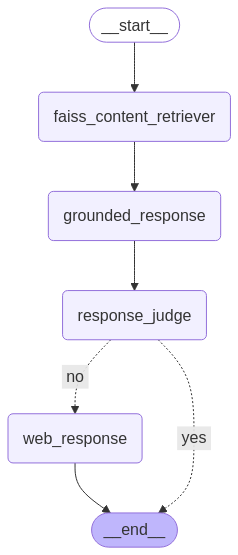

In [14]:
# Display the workflow graph as a PNG image using Mermaid
display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,  # Uses Mermaid's API to generate the PNG image of the workflow graph
        )
    )
)

In [15]:
def run_user_query(query: str) -> Dict[str, str]:
    """Process a user query through the LangGraph workflow.
    
    Args:
        query (str): The user's query
        
    Returns:
        Dict[str, str]: A dictionary containing the query's category and response
    """
    results = app.invoke({"query": query})
    return {
        # "category": results["category"],
        "response": results["response"]
    }

In [16]:

# Define the user query.
user_query = "Tell me about:  Summary Suits in Civil Proceedings under Order 37 of the CPC  "
# user_query = "How to make cake "

result = run_user_query(user_query)


Entering faiss_content_retriever

Entering grounded_response
You are an assistant that summarizes text. Given the following content:

must identify what further evidence shall be brought on record at trial that could not be brought on record at the stage of summary judgment; and (f) the reply must state why, in light of the evidence or material on record if any, the Court should not proceed to summary judgment.

comply with any order passed in a case management hearing, the court may, levy costs for such non-compliance; foreclose the non-complainant party’s right to file a   d a v i t s , c o n d u c t c r o s s examinations of witnesses, file written submissions, address oral arguments or make further arguments in trial; or, dismiss the plaint or allow the suit where such non-compliance is wilful, repeated and imposition of costs is not adequate to ensure compliance.vi. Parties are required to submit written arguments, 4 weeks prior to commencing oral arguments, followed by revised w

In [17]:
print(result["response"])

Order 37 of the CPC allows for summary suits for monetary claims on negotiable instruments, recovery of debt, or liquidated demands from written contracts or guarantees.  Only monetary decrees are permitted; other reliefs require a regular civil suit.  The defendant doesn't have an automatic right to defend but must apply for leave to defend, showing a prima facie defense. If granted, the suit becomes an ordinary suit.  The court can grant summary judgment if the plaintiff has no real prospect of success or the defendant has no real prospect of a successful defense, and there's no compelling reason to delay.  The court can also impose conditions, costs, or dismiss the suit for non-compliance with orders.

